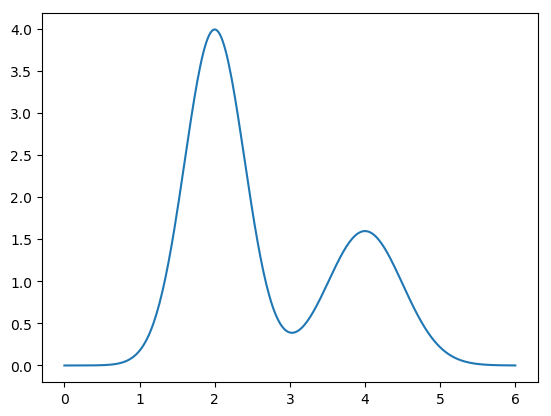

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x142944048>

In [1]:
using PyCall
include("src/gauss_error.jl")
include("src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))

In [2]:
function kernel(x::Float64, y::Float64)
    return getOpticsKernels("triangular")(x, y)
end

kernel (generic function with 1 method)

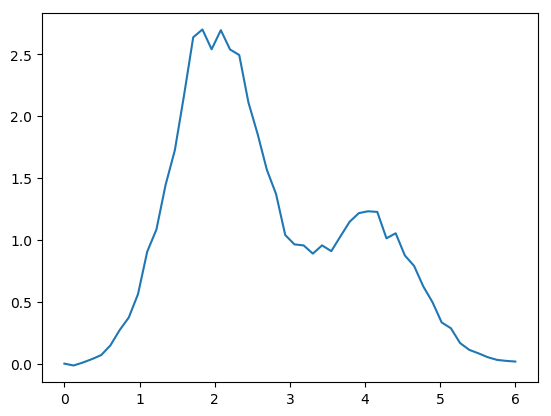

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14375b4a8>

In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, maxevals=10^7)[1]
y = collect(range(a, stop = b, length=50))
ftrue = convolution.(y)
sig = 0.05*ftrue +[0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f)

In [4]:
basis = FourierBasis(a, b, 15)

FourierBasis(0.0, 6.0, 15, BaseFunction[BaseFunction(##14#18(), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 5), (0.0, 6.0))  …  BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 11), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 11), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 12), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 12), (0.0, 

In [5]:
@time discretize_kernel(basis, kernel, y)

Kmn = discretize_kernel(basis, kernel, y)

  0.928722 seconds (10.14 M allocations: 252.103 MiB, 5.65% gc time)


50×31 Array{Float64,2}:
 0.250001  -0.455947   -0.16521    0.341958   …  -0.00810565   -0.063662  
 0.307476  -0.545703   -0.229673   0.373398       0.00825195   -0.0672769 
 0.357456  -0.611526   -0.304106   0.365501       0.0133105    -0.0401901 
 0.399935  -0.652334   -0.385436   0.318785      -0.00654113   -0.0343099 
 0.434922  -0.667458   -0.470331   0.236305       0.00211234   -0.0444834 
 0.462411  -0.656641   -0.555503   0.123459   …   0.0159871    -0.022361  
 0.482401  -0.620082   -0.63763   -0.0123768     -0.00225004   -0.00649263
 0.494901  -0.558367   -0.713458  -0.162314      -0.00352788   -0.0186005 
 0.499892  -0.472505   -0.779792  -0.316543       0.0155918    -0.00513042
 0.499998  -0.369117   -0.833841  -0.459794      -0.000519589   0.016202  
 0.5       -0.259458   -0.874202  -0.573184   …  -0.0150263    -0.00608349
 0.499999  -0.145537   -0.900201  -0.648248       0.0108981    -0.0120001 
 0.499993  -0.0292275  -0.911425  -0.682509       0.00749745    0.01437   
 

In [6]:
model = model = GaussErrorMatrixUnfolder(omega(basis, 2))

GaussErrorMatrixUnfolder(Array{Float64,2}[[1.80387 0.0 … 0.0 0.0; 0.0 1.80387 … 0.0 0.0; … ; 0.0 0.0 … 91321.0 0.0; 0.0 0.0 … 0.0 0.0]], 31, "EmpiricalBayes", nothing)

In [7]:
@time solve(model, Kmn, f, sig)

result = solve(model, Kmn, f, sig)

starting solve
ending solve
starting solve_correct
starting optimal_alpha
starting optimize
[656.885, 650.478, 644.071, 637.664, 631.257, 624.85, 618.443, 612.036, 605.629, 599.222, 592.815, 586.408, 580.001, 573.594, 567.187, 560.78, 554.373, 547.966, 541.559, 535.152, 528.745, 522.338, 515.93, 509.523, 503.116, 496.709, 490.302, 483.895, 477.488, 471.081, 464.674, 458.267, 451.86, 445.453, 439.046, 432.639, 426.232, 419.825, 413.418, 407.011, 400.604, 394.197, 387.79, 381.383, 374.976, 368.569, 362.162, 355.755, 349.348, 342.941, 336.534, 330.126, 323.719, 317.312, 310.905, 304.498, 298.091, 291.684, 285.277, 278.87, 272.463, 266.056, 259.649, 253.242, 246.835, 240.428, 234.021, 227.614, 221.207, 214.8, 208.393, 201.986, 195.579, 189.172, 182.765, 176.358, 169.951, 163.544, 157.137, 150.729, 144.322, 137.915, 131.508, 125.101, 118.694, 112.287, 105.88, 99.4732, 93.0662, 86.6591, 80.2521, 73.8451, 67.438, 61.031, 54.624, 48.2169, 41.8099, 35.4029, 28.9958, 22.5888, 16.1817, 9.77471, 3

Dict{String,Array{Float64,N} where N} with 3 entries:
  "alphas" => [0.0574333]
  "coeff"  => [1.97927, 0.883934, -0.535538, -0.627854, -0.455524, -0.665463, -…
  "sig"    => [0.00515804 0.00152905 … -5.12139e-7 -0.000919422; 0.00152905 0.0…

In [8]:
phivec = PhiVec(result["coeff"], basis, result["sig"])

PhiVec([1.97927, 0.883934, -0.535538, -0.627854, -0.455524, -0.665463, -0.0370655, -0.040777, 0.0280582, 0.00685416  …  -1.98072e-5, -6.68717e-5, -5.54258e-6, 3.26115e-5, 4.98959e-6, -2.03277e-5, -3.62067e-6, 1.0646e-5, -8.9691e-6, -0.137127], FourierBasis(0.0, 6.0, 15, BaseFunction[BaseFunction(##14#18(), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 5), (0.0, 6.0))  …  BaseFunction(##15#19{Float64,Float64,

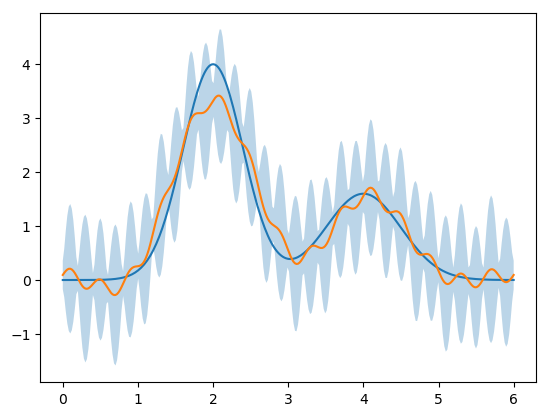

In [9]:
plot(x, phi.(x))

phi_reconstructed = call(phivec, x)
phi_reconstructed_errors = errors(phivec, x)

plot(x, call(phivec, x))
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3);

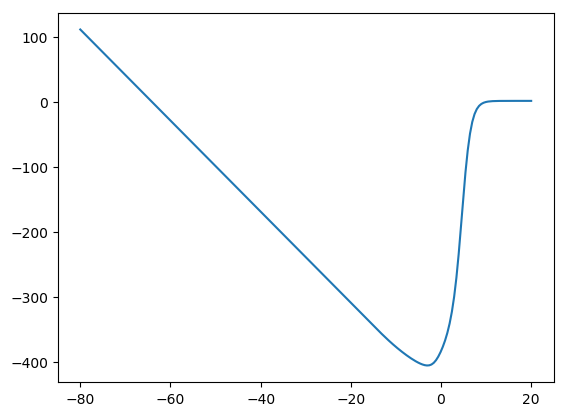

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1447895f8>

In [13]:
# -alpha_prob(x) для базиса из 15 функций
y = [110.951, 107.434, 103.916, 100.398, 96.8807, 93.3631, 89.8456, 86.328, 82.8104, 79.2928, 75.7752, 72.2576, 68.74, 65.2224, 61.7049, 58.1873, 54.6697, 51.1521, 47.6345, 44.1169, 40.5993, 37.0817, 33.5642, 30.0466, 26.529, 23.0114, 19.4938, 15.9762, 12.4586, 8.94104, 5.42345, 1.90586, -1.61172, -5.12931, -8.6469, -12.1645, -15.6821, -19.1997, -22.7173, -26.2348, -29.7524, -33.27, -36.7876, -40.3052, -43.8228, -47.3404, -50.858, -54.3755, -57.8931, -61.4107, -64.9283, -68.4459, -71.9635, -75.4811, -78.9987, -82.5162, -86.0338, -89.5514, -93.069, -96.5866, -100.104, -103.622, -107.139, -110.657, -114.175, -117.692, -121.21, -124.727, -128.245, -131.762, -135.28, -138.798, -142.315, -145.833, -149.35, -152.868, -156.386, -159.903, -163.421, -166.938, -170.456, -173.974, -177.491, -181.009, -184.526, -188.044, -191.561, -195.079, -198.597, -202.114, -205.632, -209.149, -212.667, -216.185, -219.702, -223.22, -226.737, -230.255, -233.773, -237.29, -240.808, -244.325, -247.843, -251.36, -254.878, -258.396, -261.913, -265.431, -268.948, -272.466, -275.984, -279.501, -283.019, -286.536, -290.054, -293.571, -297.089, -300.607, -304.124, -307.642, -311.159, -314.676, -318.193, -321.71, -325.226, -328.741, -332.255, -335.766, -339.273, -342.774, -346.264, -349.738, -353.188, -356.604, -359.974, -363.286, -366.531, -369.702, -372.793, -375.803, -378.73, -381.572, -384.327, -386.993, -389.564, -392.034, -394.391, -396.622, -398.707, -400.617, -402.312, -403.731, -404.773, -405.284, -405.043, -403.778, -401.216, -397.177, -391.651, -384.754, -376.557, -366.887, -355.258, -340.907, -322.827, -299.761, -270.423, -234.271, -192.63, -149.142, -108.593, -74.7703, -49.139, -31.1084, -19.0821, -11.3438, -6.47928, -3.46608, -1.61663, -0.487844, 0.198727, 0.615451, 0.868066, 1.02108, 1.11372, 1.1698, 1.20373, 1.22426, 1.23669, 1.24421, 1.24875, 1.25151, 1.25317, 1.25418, 1.25479, 1.25516, 1.25538, 1.25551, 1.2556, 1.25565]
x = collect(range(-80, 20, length=200))
plot(x, y)

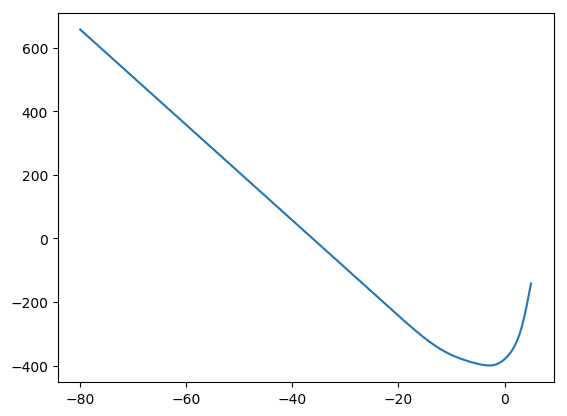

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1448dd2e8>

In [14]:
# -alpha_prob(x) для базиса из 31 функции
y = [656.885, 650.478, 644.071, 637.664, 631.257, 624.85, 618.443, 612.036, 605.629, 599.222, 592.815, 586.408, 580.001, 573.594, 567.187, 560.78, 554.373, 547.966, 541.559, 535.152, 528.745, 522.338, 515.93, 509.523, 503.116, 496.709, 490.302, 483.895, 477.488, 471.081, 464.674, 458.267, 451.86, 445.453, 439.046, 432.639, 426.232, 419.825, 413.418, 407.011, 400.604, 394.197, 387.79, 381.383, 374.976, 368.569, 362.162, 355.755, 349.348, 342.941, 336.534, 330.126, 323.719, 317.312, 310.905, 304.498, 298.091, 291.684, 285.277, 278.87, 272.463, 266.056, 259.649, 253.242, 246.835, 240.428, 234.021, 227.614, 221.207, 214.8, 208.393, 201.986, 195.579, 189.172, 182.765, 176.358, 169.951, 163.544, 157.137, 150.729, 144.322, 137.915, 131.508, 125.101, 118.694, 112.287, 105.88, 99.4732, 93.0662, 86.6591, 80.2521, 73.8451, 67.438, 61.031, 54.624, 48.2169, 41.8099, 35.4029, 28.9958, 22.5888, 16.1817, 9.77471, 3.36768, -3.03936, -9.44639, -15.8534, -22.2605, -28.6675, -35.0745, -41.4816, -47.8886, -54.2956, -60.7027, -67.1097, -73.5167, -79.9238, -86.3308, -92.7378, -99.1449, -105.552, -111.959, -118.366, -124.773, -131.18, -137.587, -143.994, -150.401, -156.808, -163.215, -169.621, -176.028, -182.434, -188.84, -195.245, -201.649, -208.051, -214.451, -220.847, -227.238, -233.621, -239.992, -246.346, -252.676, -258.974, -265.231, -271.439, -277.59, -283.675, -289.689, -295.624, -301.47, -307.215, -312.844, -318.338, -323.682, -328.858, -333.852, -338.653, -343.254, -347.652, -351.846, -355.835, -359.619, -363.198, -366.572, -369.748, -372.734, -375.546, -378.202, -380.717, -383.107, -385.38, -387.541, -389.592, -391.526, -393.333, -394.994, -396.475, -397.729, -398.687, -399.256, -399.311, -398.704, -397.274, -394.881, -391.445, -386.96, -381.461, -374.953, -367.334, -358.354, -347.63, -334.66, -318.825, -299.383, -275.57, -246.926, -213.811, -177.787, -141.48]
x = collect(range(-80, 5, length=200))
plot(x, y)